# CF regime identification for Waymo and Lyft datasets

In [3]:
import numpy as np
import pandas as pd
import utils_regime as rgm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
from joblib import Parallel, delayed

data_path = 'localdata/InputData/'
simuldata_path = 'localdata/OutputData/IDM/crossfollow/'
output_path = 'localdata/OutputData/CF regime/'

## Newell model calibration

In [4]:
def Newell_loss(x, t, x_leader, x_follower):
    tau, d, desired_v = x
    id_tau = int(tau/0.1)
    x_follower_modelled = np.zeros_like(x_follower)
    x_follower_modelled[0:id_tau] = x_follower[0:id_tau]
    for idx in range(0,len(t)-id_tau):
        x_follower_modelled[idx+id_tau] = min(x_follower_modelled[idx]+desired_v*tau, x_leader[idx]-d)
    squared_error = (x_follower_modelled[id_tau:] - x_follower[id_tau:])**2
    
    return squared_error.mean()

### Waymo

In [4]:
for cfpair in ['HA','HH','AH']:
    data = pd.read_hdf(data_path+'Waymo/CFdata/'+cfpair+'.h5', key='data')
    
    case_ids = data.case_id.unique()
    data = data.set_index('case_id')
    def calibrate_newell(case_id):
        t, x_leader, x_follower = data.loc[case_id][['time','x_leader','x_follower']].values.T
        res = minimize(Newell_loss, x0=[1.5,5,15],
                    args=(t, x_leader, x_follower),
                    bounds=((0.1,5.),(2.5,50.),(0.,30.)),
                    method='Nelder-Mead')
        if res.success:
            return res.x
        else:
            return np.zeros(3)*np.nan
        
    parameters = Parallel(n_jobs=4)(delayed(calibrate_newell)(case_id) for case_id in tqdm(case_ids))

    parameters = pd.DataFrame(parameters, columns=['tau','d','desired_v'], index=case_ids)
    parameters = parameters.dropna()
    parameters.to_csv(output_path+'Waymo/newell/newell_'+cfpair+'.csv')

  0%|          | 0/286 [00:00<?, ?it/s]

100%|██████████| 210/210 [00:02<00:00, 85.91it/s]


### Lyft

In [3]:
for cfpair in ['HA','HH','AH']:
    data = pd.read_hdf(data_path+'Lyft/CFdata/'+cfpair+'_train.h5', key='data')

    case_ids = data.case_id.unique()
    data = data.set_index('case_id')
    def calibrate_newell(case_id):
        t, x_leader, x_follower = data.loc[case_id][['time','x_leader','x_follower']].values.T
        res = minimize(Newell_loss, x0=[1.5,5,15],
                    args=(t, x_leader, x_follower),
                    bounds=((0.1,5.),(2.5,50.),(0.,30.)),
                    method='Nelder-Mead')
        if res.success:
            return res.x
        else:
            return np.zeros(3)*np.nan
        
    parameters = Parallel(n_jobs=4)(delayed(calibrate_newell)(case_id) for case_id in tqdm(case_ids))

    parameters = pd.DataFrame(parameters, columns=['tau','d','desired_v'], index=case_ids)
    parameters = parameters.dropna()
    parameters.to_csv(output_path+'Lyft/newell/newell_'+cfpair+'.csv')

100%|██████████| 8263/8263 [04:59<00:00, 27.56it/s]


### Simulated Lyft

In [5]:
def calibrate_newell(cfpair):
    data = pd.read_hdf(simuldata_path+'crossfollow_Lyft_'+cfpair+'.h5', key='data')

    case_ids = data.case_id.unique()
    data = data.set_index('case_id')
    def calibrate_newell(case_id):
        t, x_leader, x_follower = data.loc[case_id][['time','x_leader','x_follower']].values.T
        res = minimize(Newell_loss, x0=[1.5,5,15],
                    args=(t, x_leader, x_follower),
                    bounds=((0.1,5.),(2.5,50.),(0.,30.)),
                    method='Nelder-Mead')
        if res.success:
            return res.x
        else:
            return np.zeros(3)*np.nan

    parameters = Parallel(n_jobs=4)(delayed(calibrate_newell)(case_id) for case_id in tqdm(case_ids))

    parameters = pd.DataFrame(parameters, columns=['tau','d','desired_v'], index=case_ids)
    return parameters.dropna()

# leader variation
for count in tqdm(range(5)):
    for cfpair in ['fHH_lHHhigherVar','fHH_lHHlowerVar']:
        parameters = calibrate_newell(cfpair+'_'+str(count))
        parameters.to_csv(output_path+'Simulated Lyft/newell/newell_'+cfpair+'_'+str(count)+'.csv')

# follower variation
for cfpair in ['fHHhigherVar_lHH','fHHlowerVar_lHH']:
    parameters = calibrate_newell(cfpair)
    parameters.to_csv(output_path+'Simulated Lyft/newell/newell_'+cfpair+'.csv')

100%|██████████| 3765/3765 [04:28<00:00, 14.01it/s]


## Regime categorisation

In [6]:
def read_tau(cfpair, dataset='Lyft'):
    if dataset == 'Lyft':
        newell = pd.read_csv(output_path+'Lyft/newell/newell_'+cfpair+'.csv', index_col=0)
    elif dataset == 'Waymo':
        newell = pd.read_csv(output_path+'Waymo/newell/newell_'+cfpair+'.csv', index_col=0)
    elif dataset == 'Simulated Lyft':
        newell = pd.read_csv(output_path+'Simulated Lyft/newell/newell_'+cfpair+'.csv', index_col=0)
    tau_hat = newell['tau']
    return tau_hat

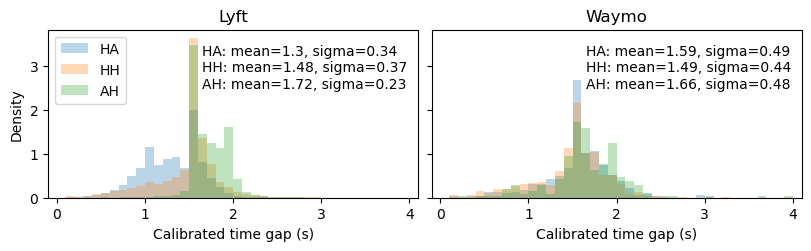

In [4]:
fig, axes = plt.subplots(1,2,figsize=(8,2.4),constrained_layout=True,sharey=True)

for ax, dataset in zip(axes, ['Lyft','Waymo']):
    tau_hat_HA = read_tau('HA', dataset)
    tau_hat_HH = read_tau('HH', dataset)
    tau_hat_AH = read_tau('AH', dataset)
    _ = ax.hist(tau_hat_HA, bins=np.arange(0,4.1,0.1), alpha=0.3, density=True, label='HA')
    _ = ax.hist(tau_hat_HH, bins=np.arange(0,4.1,0.1), alpha=0.3, density=True, label='HH')
    _ = ax.hist(tau_hat_AH, bins=np.arange(0,4.1,0.1), alpha=0.3, density=True, label='AH')
    ax.text(1.65, 2.5, 'HA: mean='+str(round(tau_hat_HA.mean(),2)) +
                      ', sigma='+str(round(tau_hat_HA.std(),2)) + '\n' +
                      'HH: mean='+str(round(tau_hat_HH.mean(),2)) +
                      ', sigma='+str(round(tau_hat_HH.std(),2)) + '\n' +
                      'AH: mean='+str(round(tau_hat_AH.mean(),2)) +
                      ', sigma='+str(round(tau_hat_AH.std(),2)))
    ax.set_xlim([-0.1,4.1])
    ax.set_xlabel('Calibrated time gap (s)')
    ax.set_title(dataset)

axes[0].set_ylabel('Density')
axes[0].legend(loc='upper left')

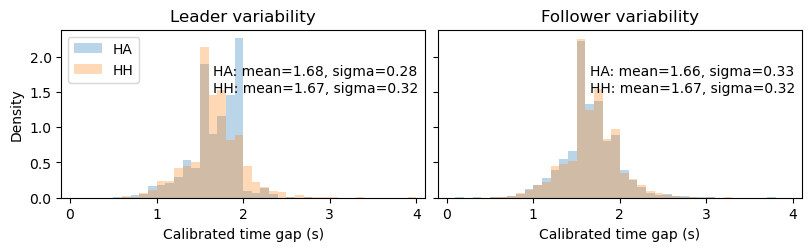

In [7]:
fig, axes = plt.subplots(1,2,figsize=(8,2.4),constrained_layout=True,sharey=True)

for ax, dataset in zip(axes, ['Leader variability','Follower variability']):
    if dataset=='Leader variability':
        count = 4
        tau_hat_HA = read_tau('fHH_lHHlowerVar'+'_'+str(count), dataset='Simulated Lyft')
        tau_hat_HH = read_tau('fHH_lHHhigherVar'+'_'+str(count), dataset='Simulated Lyft')
    elif dataset=='Follower variability':
        tau_hat_HA = read_tau('fHHlowerVar_lHH', dataset='Simulated Lyft')
        tau_hat_HH = read_tau('fHHhigherVar_lHH', dataset='Simulated Lyft')
        
    _ = ax.hist(tau_hat_HA, bins=np.arange(0,4.1,0.1), alpha=0.3, density=True, label='HA')
    _ = ax.hist(tau_hat_HH, bins=np.arange(0,4.1,0.1), alpha=0.3, density=True, label='HH')
    ax.text(1.65, 1.5, 'HA: mean='+str(round(tau_hat_HA.mean(),2)) +
                      ', sigma='+str(round(tau_hat_HA.std(),2)) + '\n' +
                      'HH: mean='+str(round(tau_hat_HH.mean(),2)) +
                      ', sigma='+str(round(tau_hat_HH.std(),2)))
    ax.set_xlim([-0.1,4.1])
    ax.set_xlabel('Calibrated time gap (s)')
    ax.set_title(dataset)

axes[0].set_ylabel('Density')
axes[0].legend(loc='upper left')

### Waymo

In [6]:
for cfpair in ['AH','HA','HH']:
    data = pd.read_hdf(data_path+'Waymo/CFdata/'+cfpair+'.h5', key='data')
    case_ids = data.case_id.unique()
    data = data.set_index('case_id')

    tau_hat = read_tau(cfpair, dataset='Waymo')
    miu_limit, sigma_limit = tau_hat.mean() + 2*tau_hat.std(), tau_hat.std() # for NGSIM, miu_limit = 5s, sigma_limit = 1.5s
    print(cfpair + ': miu limit = '+ str(round(miu_limit,2)) + ', sigma limit = ' + str(round(sigma_limit,2)))
    
    def identify_regime(case_id):
        t, x_leader, x_follower, v_leader, v_follower = data.loc[case_id][['time','x_leader','x_follower','v_leader','v_follower']].values.T
        regimes = rgm.time_regime(t, x_leader, x_follower, v_leader, v_follower, miu_limit, sigma_limit)
        regimes = pd.DataFrame({'regime':regimes, 'time':t}, index=data.loc[case_id].index)
        return regimes

    regimes_all = Parallel(n_jobs=4)(delayed(identify_regime)(case_id) for case_id in tqdm(case_ids))
    regimes_all = pd.concat(regimes_all).reset_index()
    regimes_all.to_hdf(output_path+'Waymo/regimes/regimes_all_'+cfpair+'.h5', key='regimes')

    regimes_list = (regimes_all.groupby(['case_id','regime']).time.count()/10).unstack().fillna(0)
    regimes_list = regimes_list[['Fa', 'C', 'A', 'D', 'F', 'S', 'Fd']]
    regimes_list['regime_comb'] = regimes_list.apply(lambda x: ''.join([str(i) for i in x[x>0].index]), axis=1)
    regimes_list.to_csv(output_path+'Waymo/regimes/regimes_list_'+cfpair+'.csv')

AH: miu limit = 2.61, sigma limit = 0.48


100%|██████████| 210/210 [00:44<00:00,  4.70it/s]


HA: miu limit = 2.58, sigma limit = 0.49


100%|██████████| 286/286 [00:38<00:00,  7.49it/s]


HH: miu limit = 2.37, sigma limit = 0.44


100%|██████████| 1117/1117 [04:11<00:00,  4.44it/s]


### Lyft

In [5]:
for cfpair in ['AH','HA','HH']:
    for dataset in ['val','train']:
        data = pd.read_hdf(data_path+'Lyft/CFdata/'+cfpair+'_'+dataset+'.h5', key='data')
        case_ids = data.case_id.unique()
        data = data.set_index('case_id')

        tau_hat = read_tau(cfpair, 'Lyft')
        miu_limit, sigma_limit = tau_hat.mean() + 2*tau_hat.std(), tau_hat.std() # for NGSIM, miu_limit = 5s, sigma_limit = 1.5s
        print(cfpair + ': miu limit = '+ str(round(miu_limit,2)) + ', sigma limit = ' + str(round(sigma_limit,2)))
        
        def identify_regime(case_id):
            t, x_leader, x_follower, v_leader, v_follower = data.loc[case_id][['time','x_leader','x_follower','v_leader','v_follower']].values.T
            regimes = rgm.time_regime(t, x_leader, x_follower, v_leader, v_follower, miu_limit, sigma_limit)
            regimes = pd.DataFrame({'regime':regimes, 'time':t}, index=data.loc[case_id].index)
            return regimes

        regimes_all = Parallel(n_jobs=4)(delayed(identify_regime)(case_id) for case_id in tqdm(case_ids))
        regimes_all = pd.concat(regimes_all).reset_index()
        regimes_all.to_hdf(output_path+'Lyft/regimes/regimes_all_'+cfpair+'_'+dataset+'.h5', key='regimes')

        regimes_list = (regimes_all.groupby(['case_id','regime']).time.count()/10).unstack().fillna(0)
        regimes_list = regimes_list[['Fa', 'C', 'A', 'D', 'F', 'S', 'Fd']]
        regimes_list['regime_comb'] = regimes_list.apply(lambda x: ''.join([str(i) for i in x[x>0].index]), axis=1)
        regimes_list.to_csv(output_path+'Lyft/regimes/regimes_list_'+cfpair+'_'+dataset+'.csv')
    
    regimes_all_train = pd.read_hdf(output_path+'Lyft/regimes/regimes_all_'+cfpair+'_train.h5', key='regimes')
    regimes_all_val = pd.read_hdf(output_path+'Lyft/regimes/regimes_all_'+cfpair+'_val.h5', key='regimes')
    regimes_all_train['case_id'] = (regimes_all_train['case_id'] + 1e5 ).astype(int)
    regimes_all_val['case_id'] = (regimes_all_val['case_id'] + 3e5 ).astype(int)
    regimes_all = pd.concat([regimes_all_train, regimes_all_val], ignore_index=True)
    regimes_all.to_hdf(output_path+'Lyft/regimes/regimes_all_'+cfpair+'.h5', key='regimes')

    regimes_list_train = pd.read_csv(output_path+'Lyft/regimes/regimes_list_'+cfpair+'_train.csv')
    regimes_list_val = pd.read_csv(output_path+'Lyft/regimes/regimes_list_'+cfpair+'_val.csv')
    regimes_list_train['case_id'] = (regimes_list_train['case_id'] + 1e5 ).astype(int)
    regimes_list_val['case_id'] = (regimes_list_val['case_id'] + 3e5 ).astype(int)
    regimes_list = pd.concat([regimes_list_train, regimes_list_val], ignore_index=True)
    regimes_list.to_csv(output_path+'Lyft/regimes/regimes_list_'+cfpair+'.csv', index=False)

AH: miu limit = 2.17, sigma limit = 0.23


100%|██████████| 909/909 [03:24<00:00,  4.45it/s]


AH: miu limit = 2.17, sigma limit = 0.23


100%|██████████| 8263/8263 [33:59<00:00,  4.05it/s]  


HA: miu limit = 1.98, sigma limit = 0.34


100%|██████████| 3055/3055 [18:03<00:00,  2.82it/s]


HA: miu limit = 1.98, sigma limit = 0.34


100%|██████████| 26394/26394 [2:36:22<00:00,  2.81it/s]  


HH: miu limit = 2.22, sigma limit = 0.37


100%|██████████| 4209/4209 [10:18<00:00,  6.80it/s]


HH: miu limit = 2.22, sigma limit = 0.37


100%|██████████| 38683/38683 [2:11:59<00:00,  4.88it/s]  


### Simulated Lyft

In [8]:
def determine_regime(cfpair):
    data = pd.read_hdf(simuldata_path+'crossfollow_Lyft_'+cfpair+'.h5', key='data')
    case_ids = data.case_id.unique()
    data = data.set_index('case_id')

    tau_hat = read_tau(cfpair, dataset='Simulated Lyft')
    miu_limit, sigma_limit = tau_hat.mean() + 2*tau_hat.std(), tau_hat.std() # for NGSIM, miu_limit = 5s, sigma_limit = 1.5s
    print(cfpair + ': miu limit = '+ str(round(miu_limit,2)) + ', sigma limit = ' + str(round(sigma_limit,2)))
    
    def identify_regime(case_id):
        t, x_leader, x_follower, v_leader, v_follower = data.loc[case_id][['time','x_leader','x_follower','v_leader','v_follower']].values.T
        regimes = rgm.time_regime(t, x_leader, x_follower, v_leader, v_follower, miu_limit, sigma_limit)
        regimes = pd.DataFrame({'regime':regimes, 'time':t}, index=data.loc[case_id].index)
        return regimes

    regimes_all = Parallel(n_jobs=4)(delayed(identify_regime)(case_id) for case_id in tqdm(case_ids))
    regimes_all = pd.concat(regimes_all).reset_index()
    regimes_all.to_hdf(output_path+'Simulated Lyft/regimes/regimes_all_'+cfpair+'.h5', key='regimes')

    regimes_list = (regimes_all.groupby(['case_id','regime']).time.count()/10).unstack().fillna(0)
    try:
        print(len(regimes_list['Fd']))
    except:
        regimes_list = regimes_list.copy()
        regimes_list['Fd'] = 0.0
    regimes_list = regimes_list[['Fa', 'C', 'A', 'D', 'F', 'S', 'Fd']]
    regimes_list['regime_comb'] = regimes_list.apply(lambda x: ''.join([str(i) for i in x[x>0].index]), axis=1)
    regimes_list.to_csv(output_path+'Simulated Lyft/regimes/regimes_list_'+cfpair+'.csv')

# leader variation
for count in range(2,5):
    for cfpair in ['fHH_lHHhigherVar','fHH_lHHlowerVar']:
        determine_regime(cfpair+'_'+str(count))

# follower variation
for cfpair in ['fHHhigherVar_lHH','fHHlowerVar_lHH']:
    determine_regime(cfpair)

fHHhigherVar_lHH: miu limit = 2.31, sigma limit = 0.32


100%|██████████| 3618/3618 [11:29<00:00,  5.25it/s]


3618
fHHlowerVar_lHH: miu limit = 2.32, sigma limit = 0.33


100%|██████████| 3765/3765 [14:03<00:00,  4.47it/s]


3765
